In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [21]:
import json
import os
from os.path import join

########## backgrounds ##########
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbackgrounds_v2.json'))) # skimmedbkg_bTags.json
bkgscales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_v2.json')))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/skimmed_control_data2018_v2.json')))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
# datasets.update(datadatasets) # skip data for now

mapping = {}
mapping.update(bkgmapping)
# mapping.update(datamapping)
####################################

In [22]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

# common plotting options
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

In [4]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#AK4CHS jets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
#         mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 20, 0, 500)
        
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'njets': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'pt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            'ht': hist.Hist('Counts', dataset_axis, ht_axis, channel_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
        )

        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets = leptonjets[leptonjets.isneutral] # veto qsum!=0 mu-type leptonjets
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets[isControl]
        ak4jets = ak4jets[isControl]
        if leptonjets_.size==0: return output
        wgt = wgt[isControl]
        lj0 = lj0[isControl]
        lj1 = lj1[isControl]
        channel_ = channel_[isControl]

        ak4jets=ak4jets[ak4jets.jetid] ## jetid!!
        output['njets'].fill(dataset=dataset, multiplicity=ak4jets.jetid.sum(), weight=wgt, channel=channel_)
        output['ht'].fill(dataset=dataset, ht=ak4jets.pt.sum(), weight=wgt, channel=channel_)
        jwgt = (ak4jets.pt.ones_like()*wgt).flatten()
        jchannel = (ak4jets.pt.ones_like()*channel_).flatten()
        output['pt'].fill(dataset=dataset, pt=ak4jets.pt.flatten(), weight=jwgt, channel=jchannel)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [14]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 25/25 [00:03<00:00,  8.28items/s]


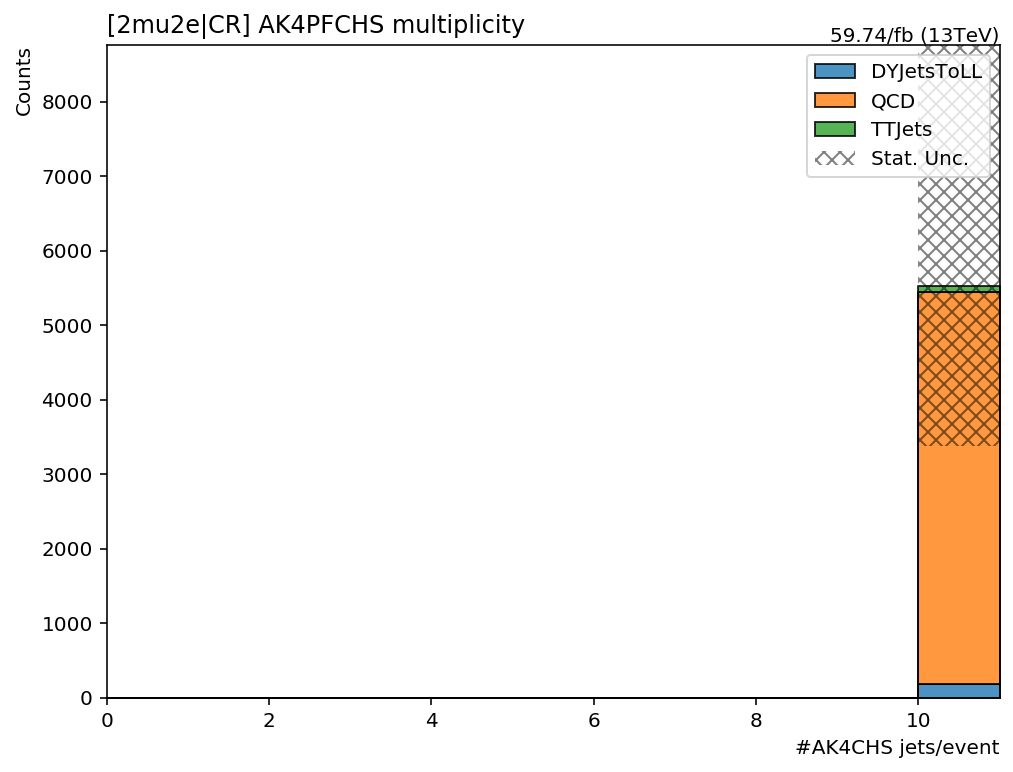

In [15]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['njets_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|CR] AK4PFCHS multiplicity', x=0.0, ha="left");

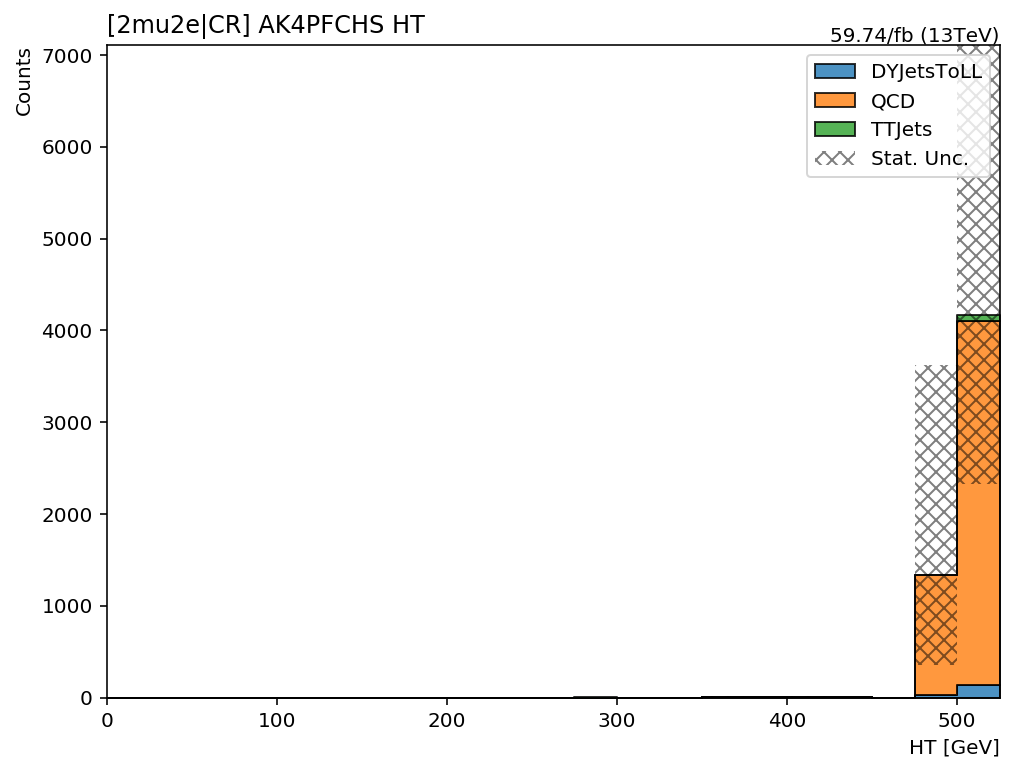

In [16]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ht_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|CR] AK4PFCHS HT', x=0.0, ha="left");

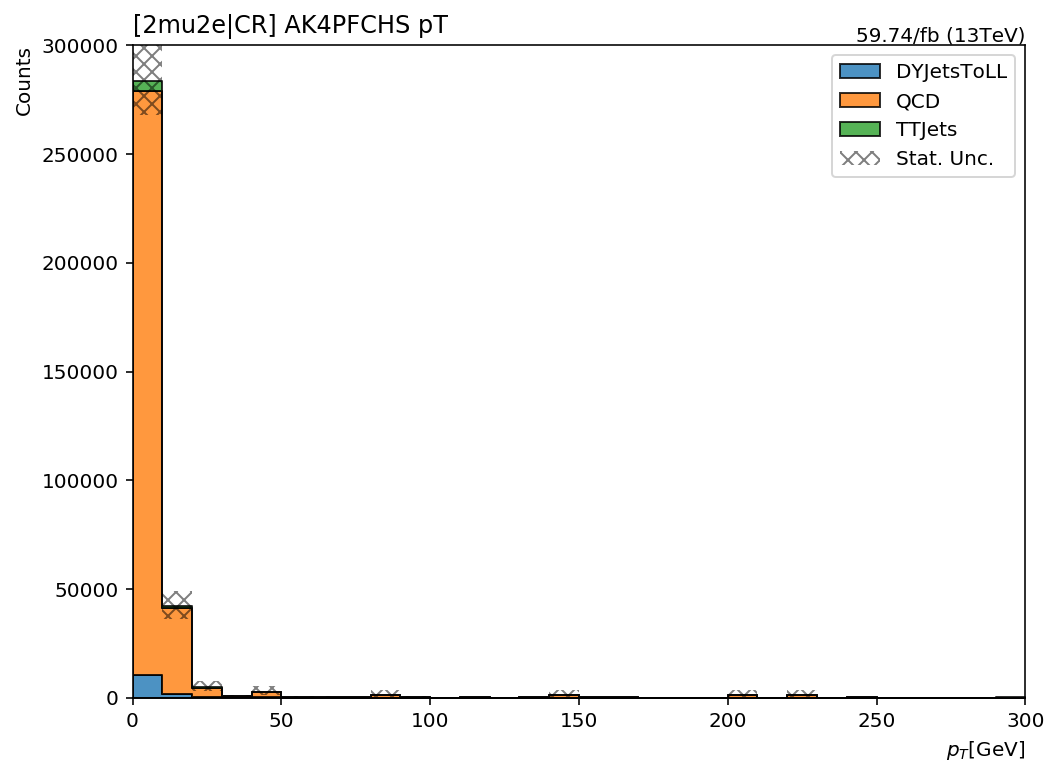

In [17]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['pt_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|CR] AK4PFCHS pT', x=0.0, ha="left");

## All region

In [23]:
ptbinning = np.concatenate([np.arange(0, 100, 5),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "# jets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
#         mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -5.2, 5.2)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 20, 0, 500)
        iso_axis = hist.Bin('iso', 'iso value', 20, 0, 1)
        
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'njets': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'pt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            'eta': hist.Hist('Counts', dataset_axis, eta_axis, channel_axis),
            'ht': hist.Hist('Counts', dataset_axis, ht_axis, channel_axis),
            'nlj': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'ljpfiso': hist.Hist('Counts', dataset_axis, iso_axis, channel_axis),
            'ljcands': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'nmuons': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'mupt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
            hadfrac=df['akjet_ak4PFJetsCHS_hadronEnergyFraction'],
            emfrac=df['akjet_ak4PFJetsCHS_emEnergyFraction'],
        )
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],
            selector=df['muon_selectors']
        )
        muons.add_attributes(isoloose=np.bitwise_and(muons.selector, 1<<7).astype(bool),
                             isomedium=np.bitwise_and(muons.selector, 1<<8).astype(bool),
                             isotight=np.bitwise_and(muons.selector, 1<<9).astype(bool),
                            )

        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfiso=df['pfjet_pfIsolation05'],
            ncands=df['pfjet_pfcands_n'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets = leptonjets[leptonjets.isneutral] # veto qsum!=0 mu-type leptonjets
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        muons = muons[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets
        ak4jets = ak4jets
        muons = muons
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>20)&(np.abs(ak4jets.eta)<5.2)]
        muons=muons[(muons.pt>5.)&(muons.isoloose)]
        
        output['njets'].fill(dataset=dataset, multiplicity=ak4jets.counts, weight=wgt, channel=channel_)
        output['ht'].fill(dataset=dataset, ht=ak4jets.pt.sum(), weight=wgt, channel=channel_)
        output['nmuons'].fill(dataset=dataset, multiplicity=muons.counts, weight=wgt, channel=channel_)
        
        mwgt = (muons.pt.ones_like()*wgt).flatten()
        mchannel = (muons.pt.ones_like()*channel_).flatten()
        output['mupt'].fill(dataset=dataset, pt=muons.pt.flatten(), weight=mwgt, channel=mchannel)
        
        jwgt = (ak4jets.pt.ones_like()*wgt).flatten()
        jchannel = (ak4jets.pt.ones_like()*channel_).flatten()
        output['pt'].fill(dataset=dataset, pt=ak4jets.pt.max(), weight=wgt, channel=channel_)
        output['eta'].fill(dataset=dataset, eta=ak4jets.eta.flatten(), weight=jwgt, channel=jchannel)
        
        ljwgt = (dileptonjets.pt.ones_like()*wgt).flatten()
        ljchannel=(dileptonjets.pt.ones_like()*channel_).flatten()
        output['nlj'].fill(dataset=dataset, multiplicity=dileptonjets.counts, weight=wgt, channel=channel_)
        
        
        egammalj = dileptonjets[dileptonjets.iseltype] # iseltype
        egwgt = (egammalj.pt.ones_like()*wgt).flatten()
        egchannel = (egammalj.pt.ones_like()*channel_).flatten()
        output['ljcands'].fill(dataset=dataset, multiplicity=egammalj.ncands.flatten(), weight=egwgt, channel=egchannel)
        output['ljpfiso'].fill(dataset=dataset, iso=egammalj.pfiso.flatten(), weight=egwgt, channel=egchannel)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [24]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:02<00:00,  4.97items/s]


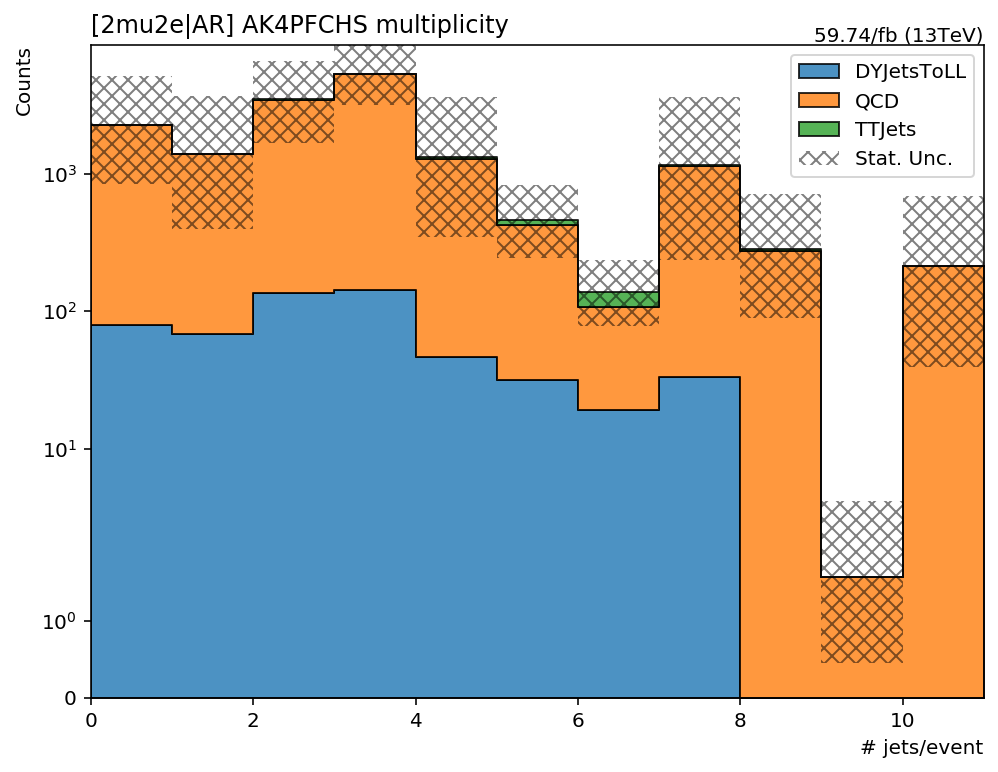

In [7]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['njets_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS multiplicity', x=0.0, ha="left");

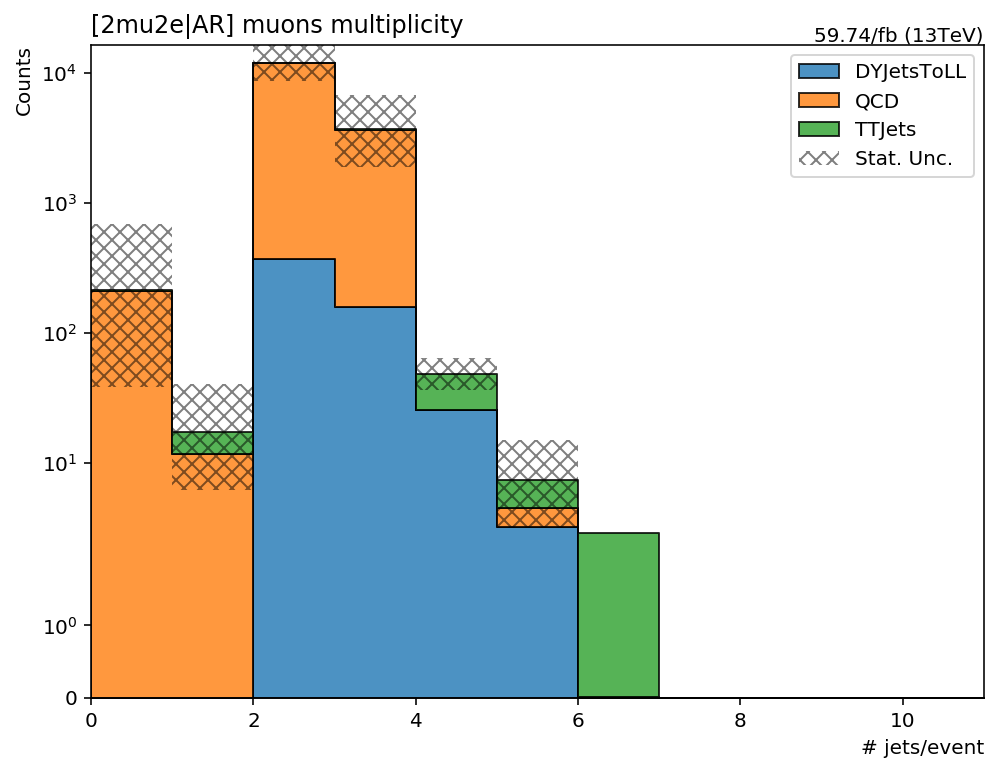

In [22]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['nmuons_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] muons multiplicity', x=0.0, ha="left");

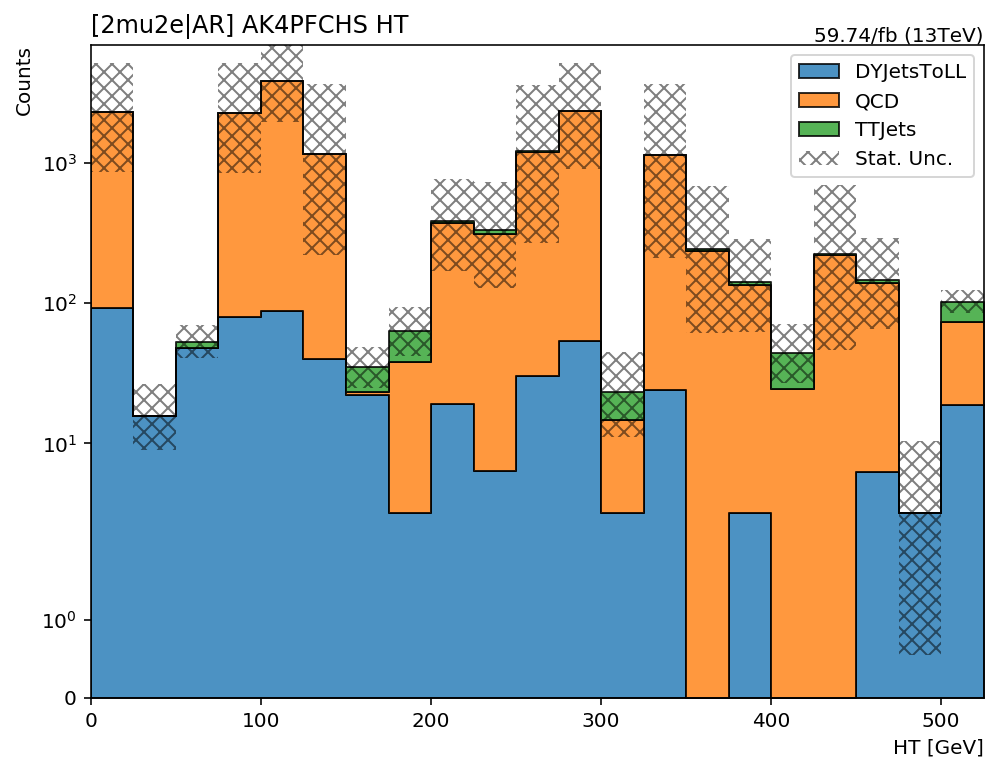

In [8]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ht_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS HT', x=0.0, ha="left");

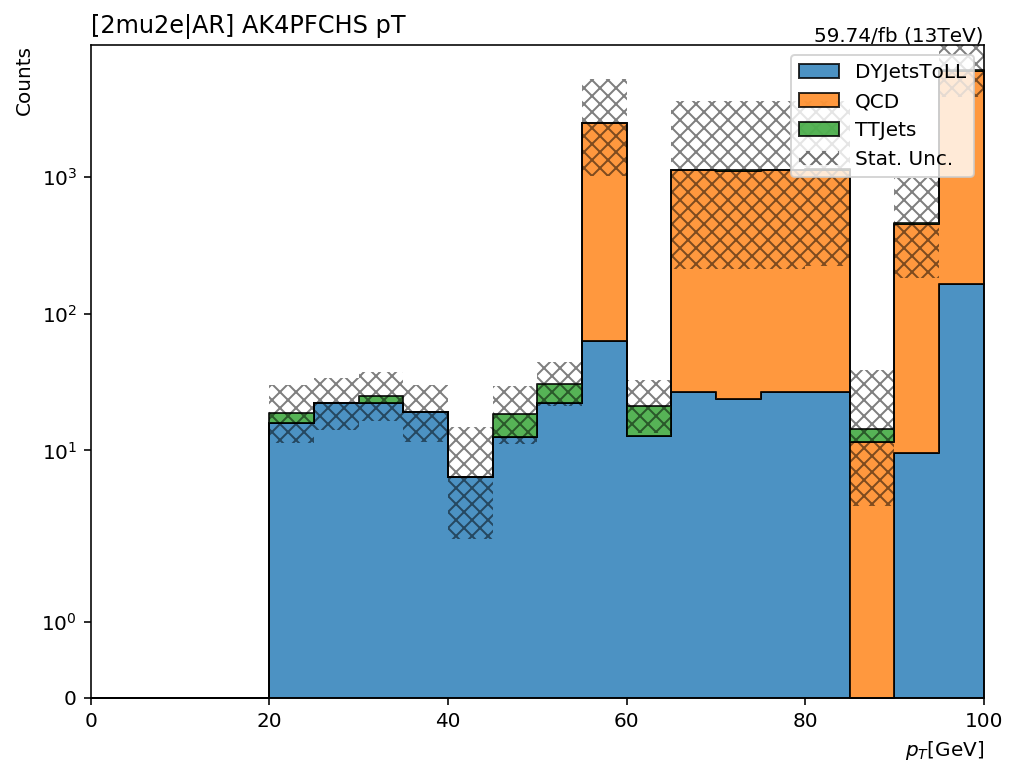

In [9]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['pt_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS pT', x=0.0, ha="left");

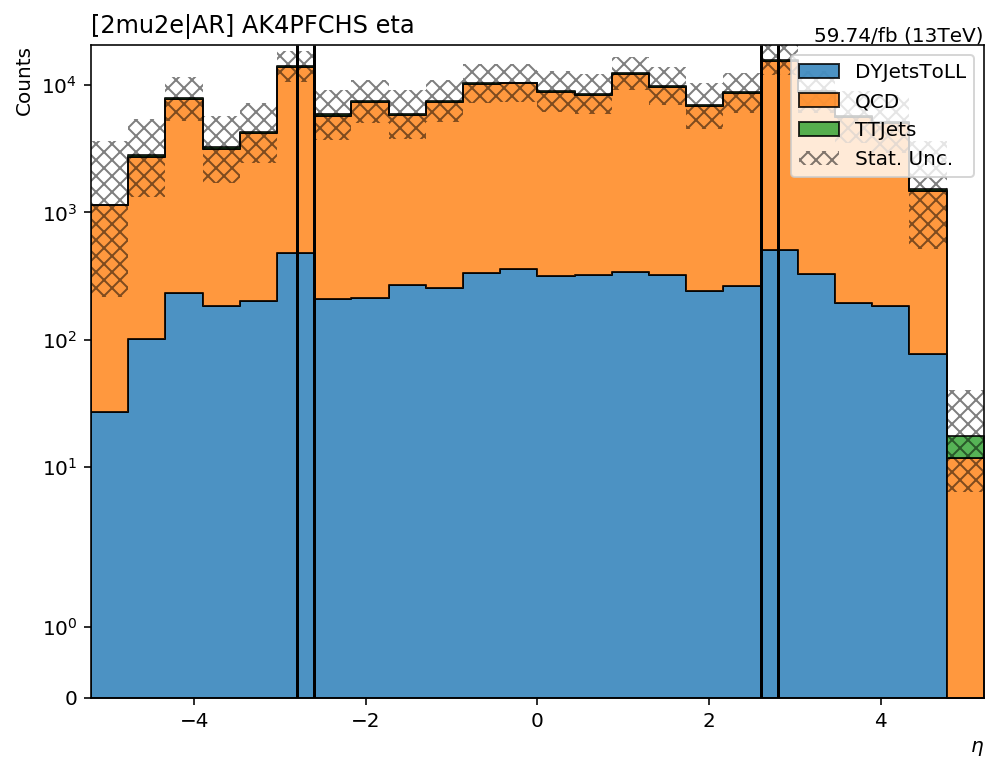

In [26]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['eta_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='none',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.vlines([-2.8, -2.6, 2.6, 2.8], 0, 1, transform=ax.get_xaxis_transform())
ax.set_title('[2mu2e|AR] AK4PFCHS eta', x=0.0, ha="left");

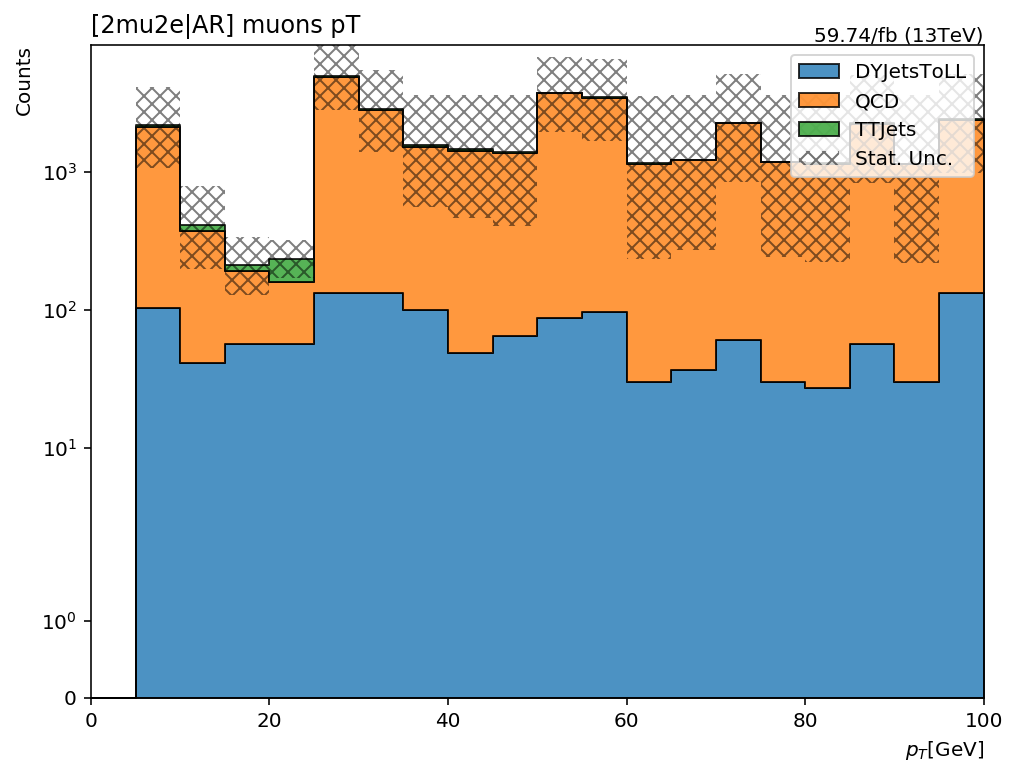

In [40]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['mupt_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] muons pT', x=0.0, ha="left");

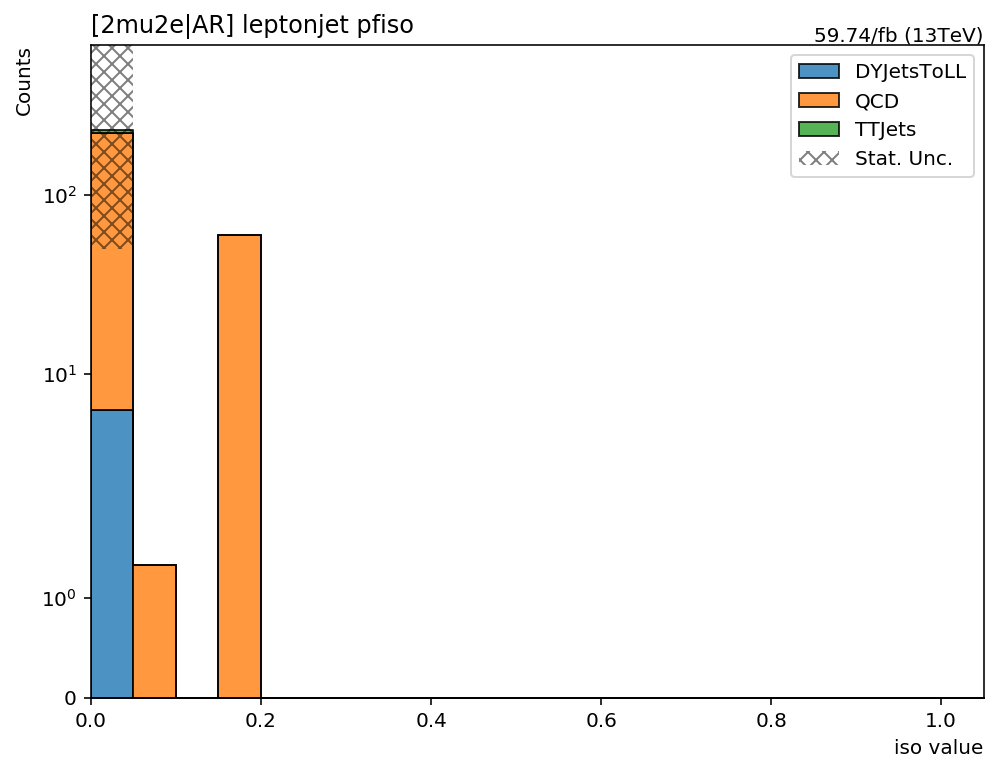

In [25]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljpfiso_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] leptonjet pfiso', x=0.0, ha="left");

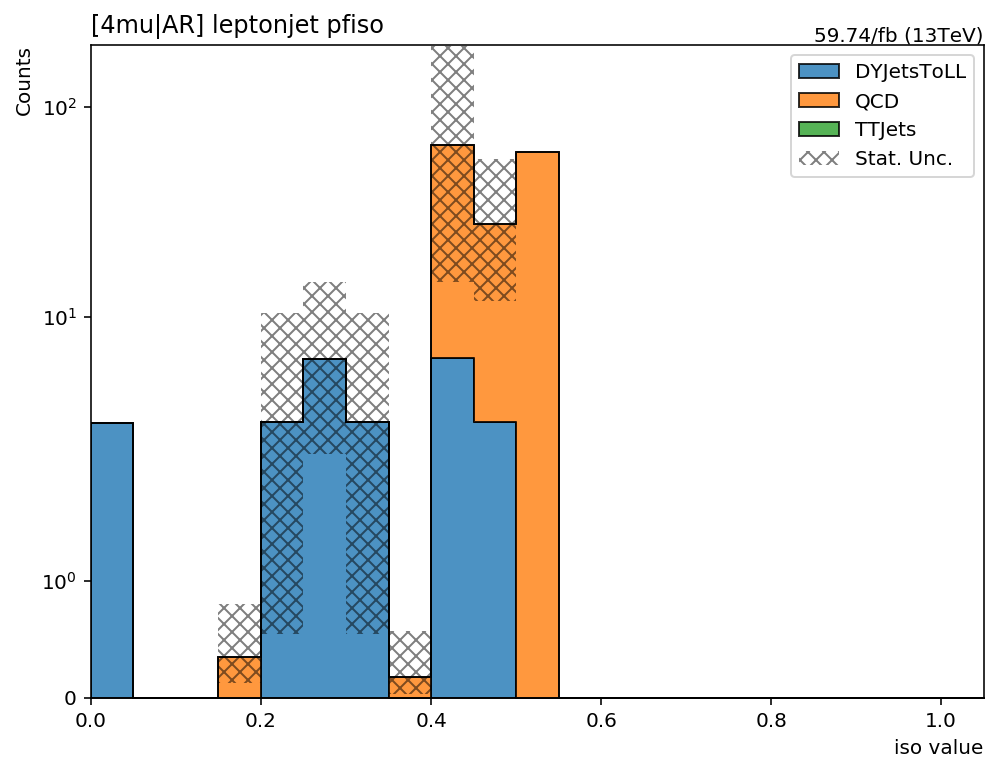

In [12]:
## This need to adjust the processor to select `ismutype` leptonjet
## otherwise the plot is not meaningful.

fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljpfiso_cat'][notdata].integrate('channel', slice(2,3)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[4mu|AR] leptonjet pfiso', x=0.0, ha="left");

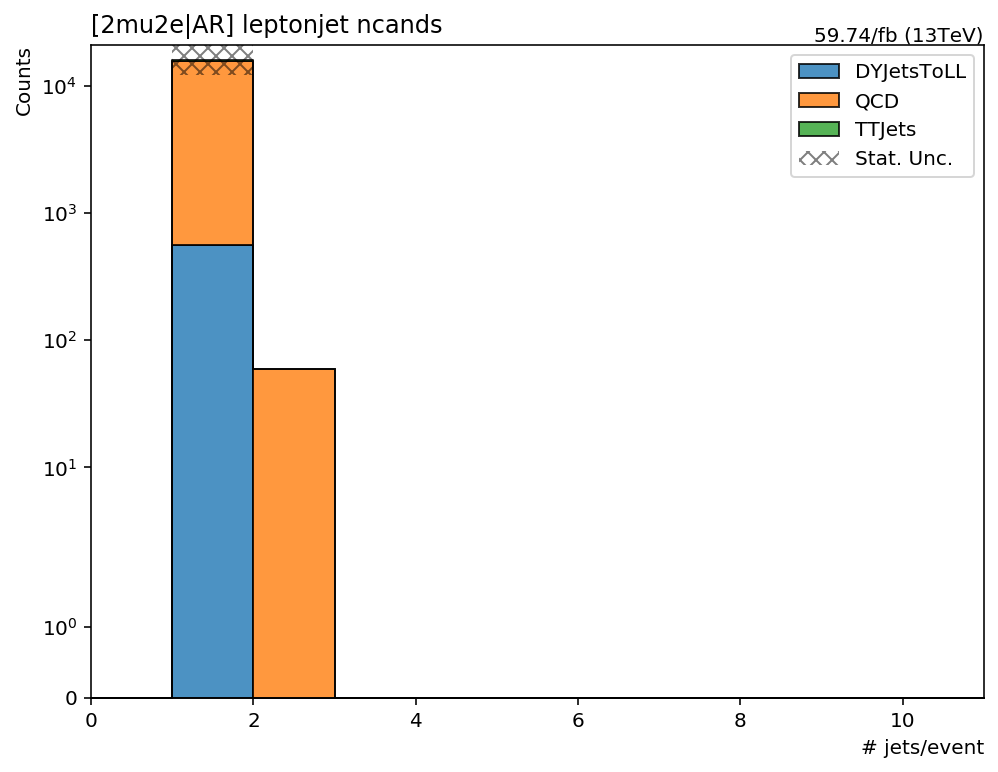

In [43]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] leptonjet ncands', x=0.0, ha="left");

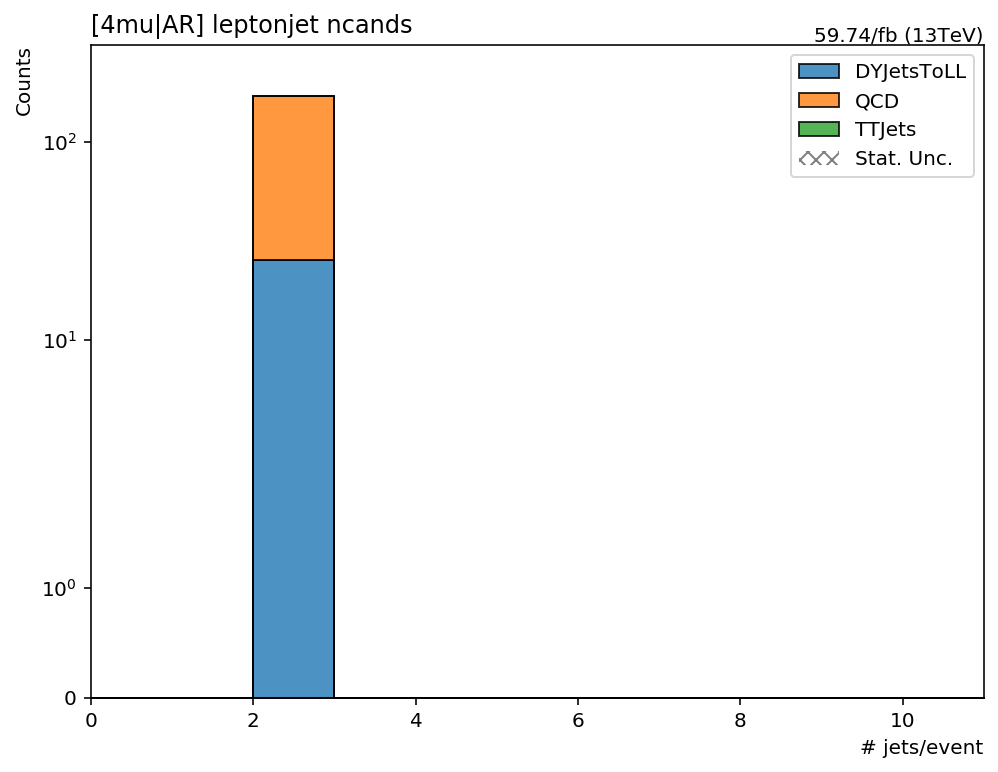

In [23]:
## This need to adjust the processor to select `ismutype` leptonjet
## otherwise the plot is not meaningful.

fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands_cat'][notdata].integrate('channel', slice(2,3)),
                   overlay='cat',
                   ax=ax,
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
leg=ax.legend()
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[4mu|AR] leptonjet ncands', x=0.0, ha="left");

# signal

In [4]:
dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2-1.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2-1.json')))

In [18]:
ptbinning = np.concatenate([np.arange(0, 100, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'datasets')
        multiplicity_axis = hist.Bin("multiplicity", "# jets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
#         mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -5.2, 5.2)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 20, 0, 500)
        iso_axis = hist.Bin('iso', 'iso value', 20, 0, 1)
        
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'njets': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'pt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            'eta': hist.Hist('Counts', dataset_axis, eta_axis, channel_axis),
            'ht': hist.Hist('Counts', dataset_axis, ht_axis, channel_axis),
            'nlj': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'ljpfiso': hist.Hist('Counts', dataset_axis, iso_axis, channel_axis),
            'ljcands': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'nmuons': hist.Hist('Counts', dataset_axis, multiplicity_axis, channel_axis),
            'mupt': hist.Hist('Counts', dataset_axis, pt_axis, channel_axis),
            
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
#         if len(dataset)!=1:
#             wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
            hadfrac=df['akjet_ak4PFJetsCHS_hadronEnergyFraction'],
            emfrac=df['akjet_ak4PFJetsCHS_emEnergyFraction'],
        )
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],
            selector=df['muon_selectors']
        )
        muons.add_attributes(isoloose=np.bitwise_and(muons.selector, 1<<7).astype(bool),
                             isomedium=np.bitwise_and(muons.selector, 1<<8).astype(bool),
                             isotight=np.bitwise_and(muons.selector, 1<<9).astype(bool),
                             idloose=np.bitwise_and(muons.selector, 1<<0).astype(bool),
                             miniisoloose=np.bitwise_and(muons.selector, 1<<18).astype(bool),
                            )

        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfiso=df['pfjet_pfIsolation05'],
            ncands=df['pfjet_pfcands_n'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets = leptonjets[leptonjets.isneutral] # veto qsum!=0 mu-type leptonjets
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        muons = muons[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets
        ak4jets = ak4jets
        muons = muons
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>20)&(np.abs(ak4jets.eta)<5.2)]
        muons=muons[(muons.pt>5.)&(muons.isoloose)&muons.idloose]
        
        output['njets'].fill(dataset=dataset, multiplicity=ak4jets.jetid.sum(), weight=wgt, channel=channel_)
        output['ht'].fill(dataset=dataset, ht=ak4jets.pt.sum(), weight=wgt, channel=channel_)
        output['nmuons'].fill(dataset=dataset, multiplicity=muons.counts, weight=wgt, channel=channel_)
        
        mwgt = (muons.pt.ones_like()*wgt).flatten()
        mchannel = (muons.pt.ones_like()*channel_).flatten()
        output['mupt'].fill(dataset=dataset, pt=muons.pt.flatten(), weight=mwgt, channel=mchannel)
        
        jwgt = (ak4jets.pt.ones_like()*wgt).flatten()
        jchannel = (ak4jets.pt.ones_like()*channel_).flatten()
        output['pt'].fill(dataset=dataset, pt=ak4jets.pt.max().flatten(), weight=wgt, channel=channel_)
        output['eta'].fill(dataset=dataset, eta=ak4jets.eta.flatten(), weight=jwgt, channel=jchannel)
        
        ljwgt = (dileptonjets.pt.ones_like()*wgt).flatten()
        ljchannel=(dileptonjets.pt.ones_like()*channel_).flatten()
        output['nlj'].fill(dataset=dataset, multiplicity=dileptonjets.counts, weight=wgt, channel=channel_)
        
        
        egammalj = dileptonjets[dileptonjets.iseltype] # `iseltype`
        egwgt = (egammalj.pt.ones_like()*wgt).flatten()
        egchannel = (egammalj.pt.ones_like()*channel_).flatten()
        output['ljcands'].fill(dataset=dataset, multiplicity=egammalj.ncands.flatten(), weight=egwgt, channel=egchannel)
        output['ljpfiso'].fill(dataset=dataset, iso=egammalj.pfiso.flatten(), weight=egwgt, channel=egchannel)
        
        return output
    
    def postprocess(self, accumulator):
#         origidentity = list(accumulator)        
#         for k in origidentity:
#             accumulator[k].scale(bkgscales, axis='dataset')
#             accumulator[k+'_cat'] = accumulator[k].group("dataset",
#                                                          hist.Cat("cat", "datasets"),
#                                                          mapping)
        return accumulator

In [19]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 16/16 [00:07<00:00,  1.42items/s]


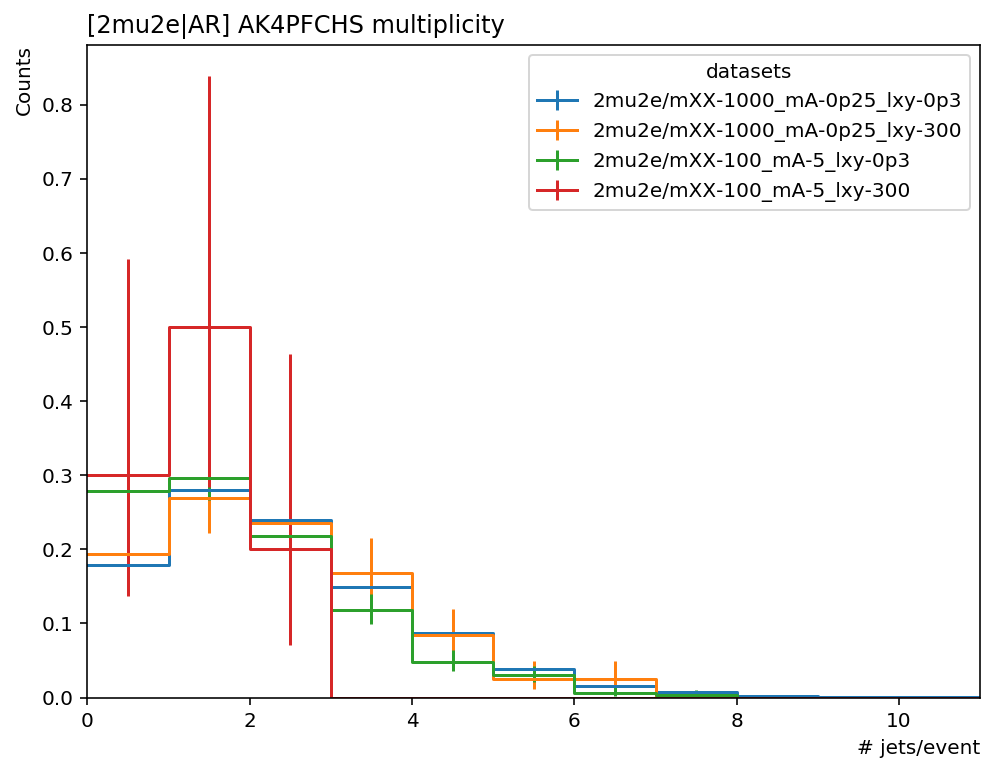

In [7]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['njets']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS multiplicity', x=0.0, ha="left");

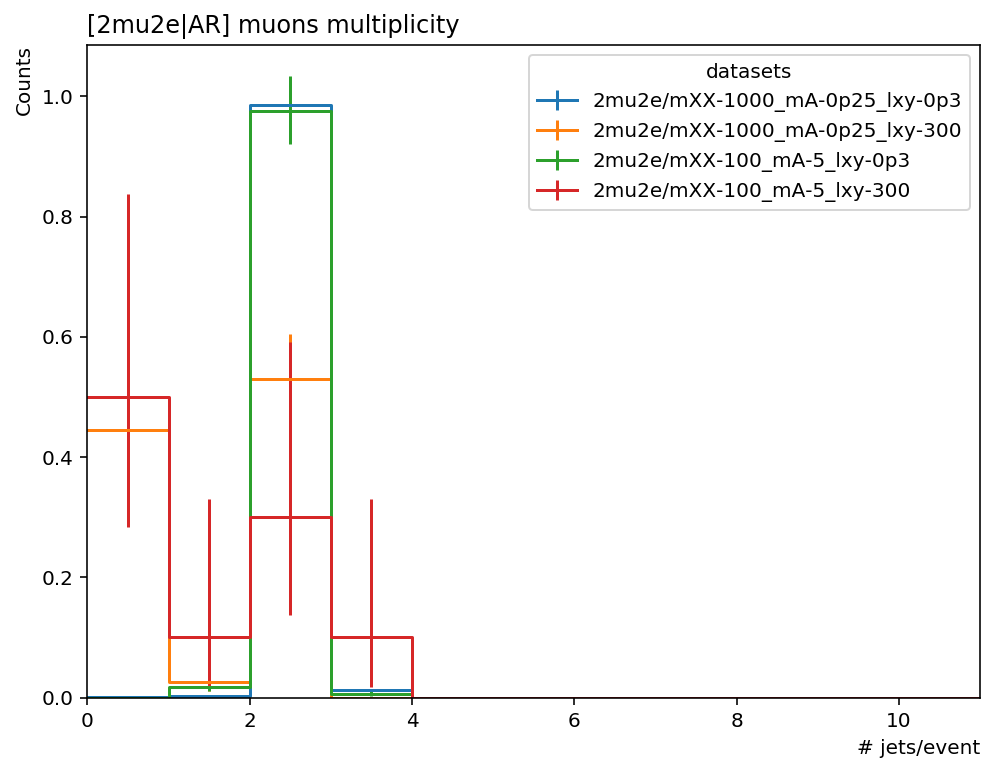

In [53]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['nmuons']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] muons multiplicity', x=0.0, ha="left");

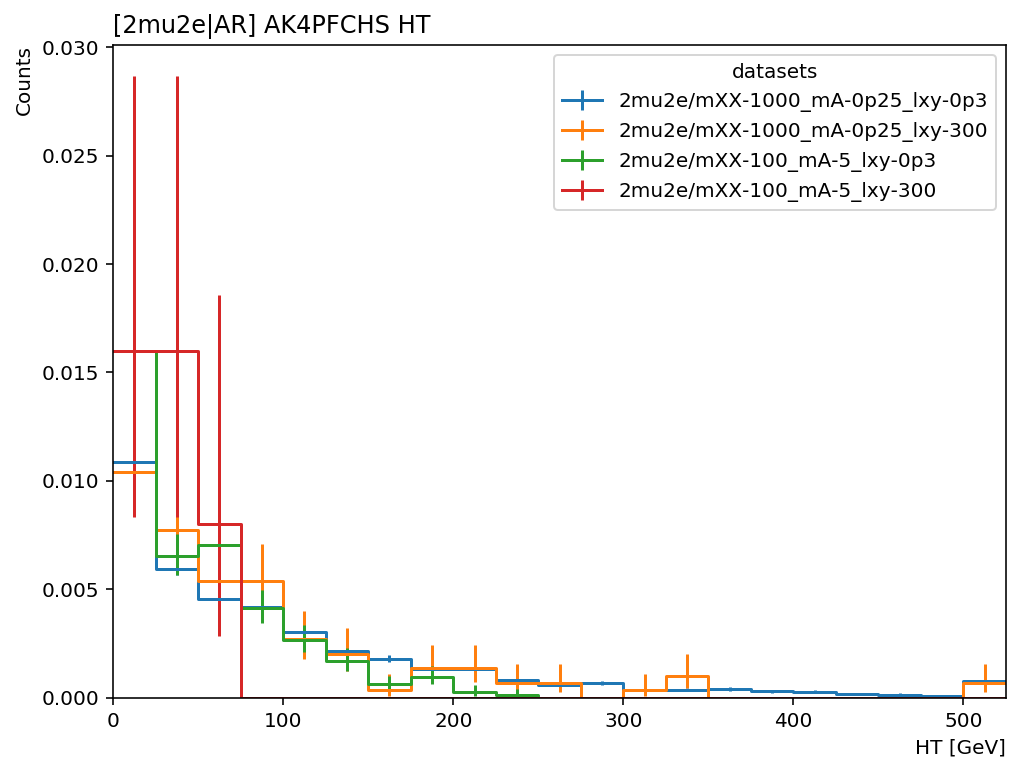

In [14]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ht']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS HT', x=0.0, ha="left");

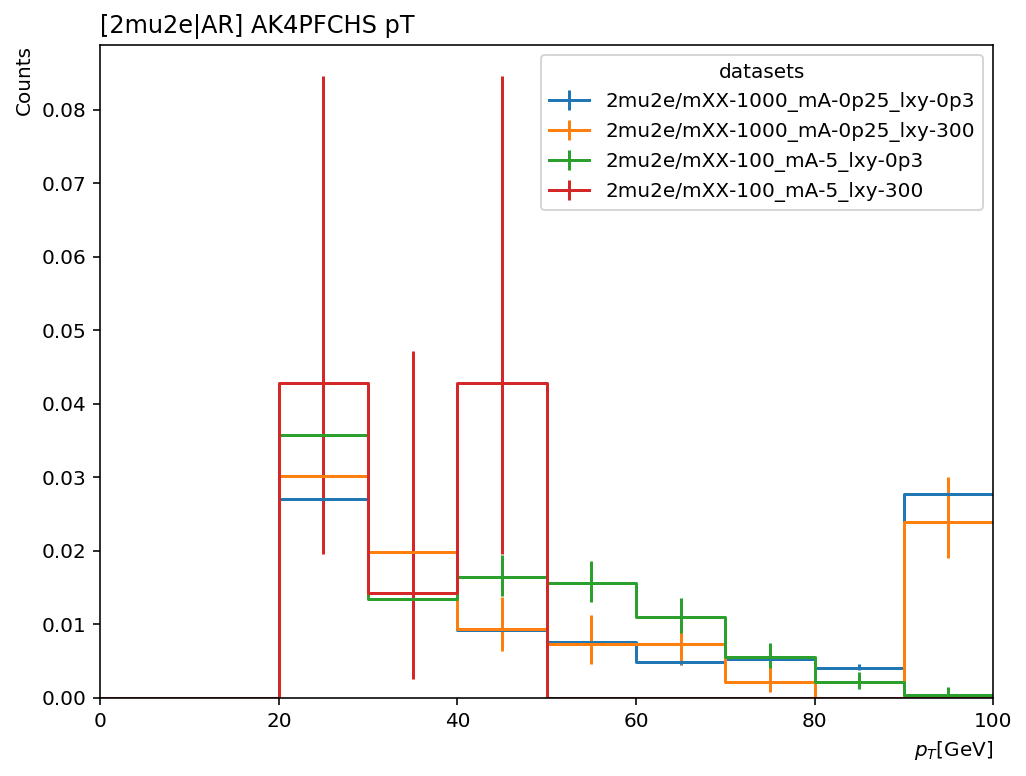

In [15]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['pt']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([40,], 0, 1, transform=ax.get_xaxis_transform())
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS pT', x=0.0, ha="left");

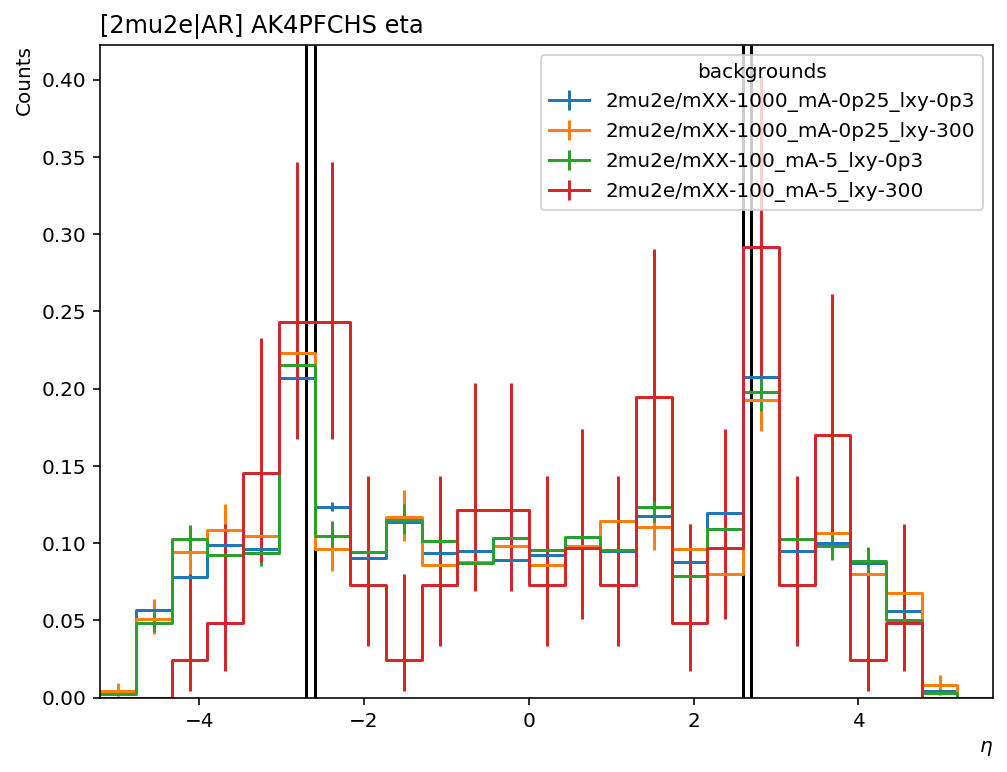

In [35]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['eta']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.vlines([-2.7, -2.6, 2.6, 2.7], 0, 1, transform=ax.get_xaxis_transform())
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] AK4PFCHS eta', x=0.0, ha="left");

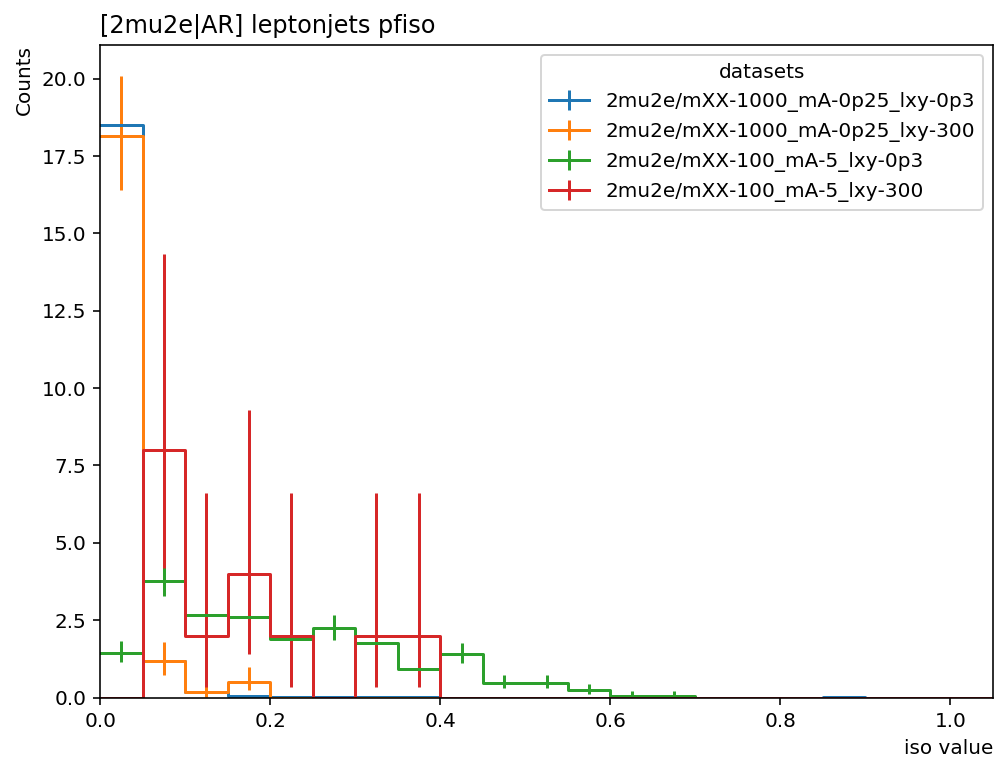

In [20]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljpfiso']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([-2.7, -2.6, 2.6, 2.7], 0, 1, transform=ax.get_xaxis_transform())
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] leptonjets pfiso', x=0.0, ha="left");

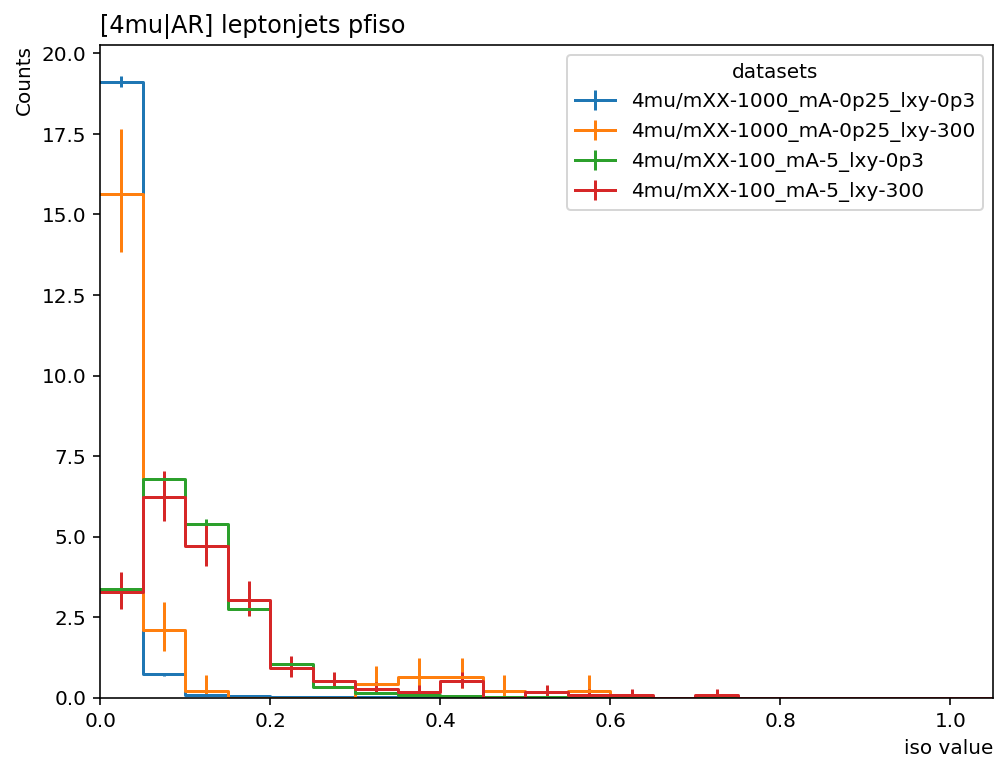

In [13]:
## This need to adjust the processor to select `ismutype` leptonjet
## otherwise the plot is not meaningful.

fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljpfiso']['4mu/*'].integrate('channel', slice(2,3)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([-2.7, -2.6, 2.6, 2.7], 0, 1, transform=ax.get_xaxis_transform())
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[4mu|AR] leptonjets pfiso', x=0.0, ha="left");

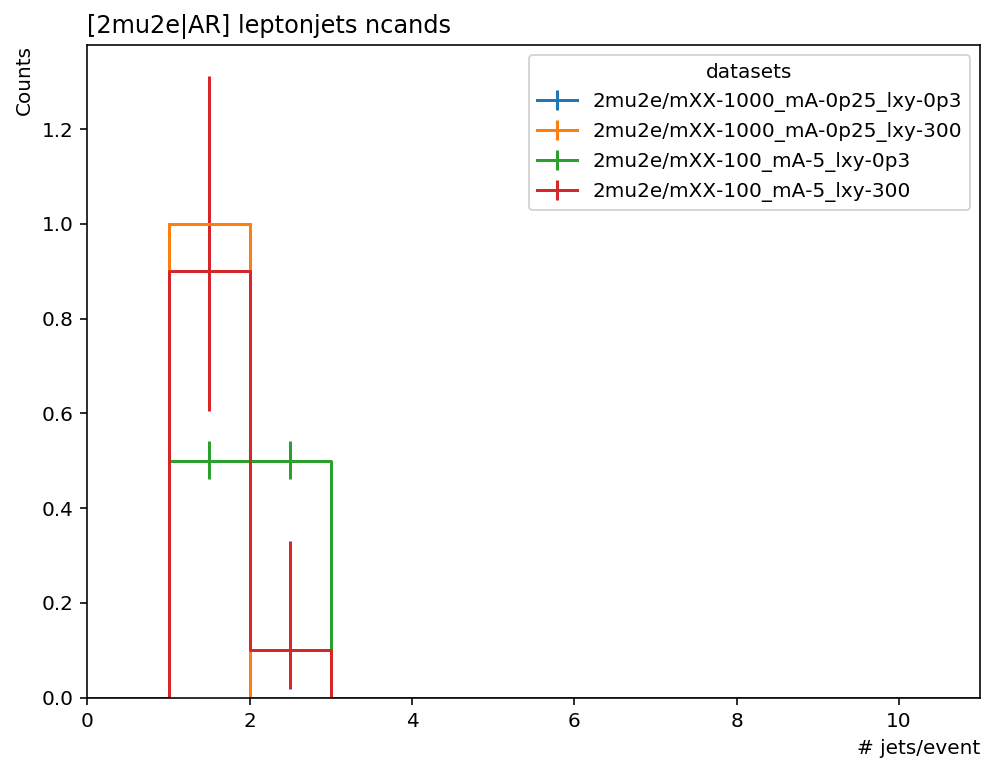

In [9]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([-2.7, -2.6, 2.6, 2.7], 0, 1, transform=ax.get_xaxis_transform())
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[2mu2e|AR] leptonjets ncands', x=0.0, ha="left");

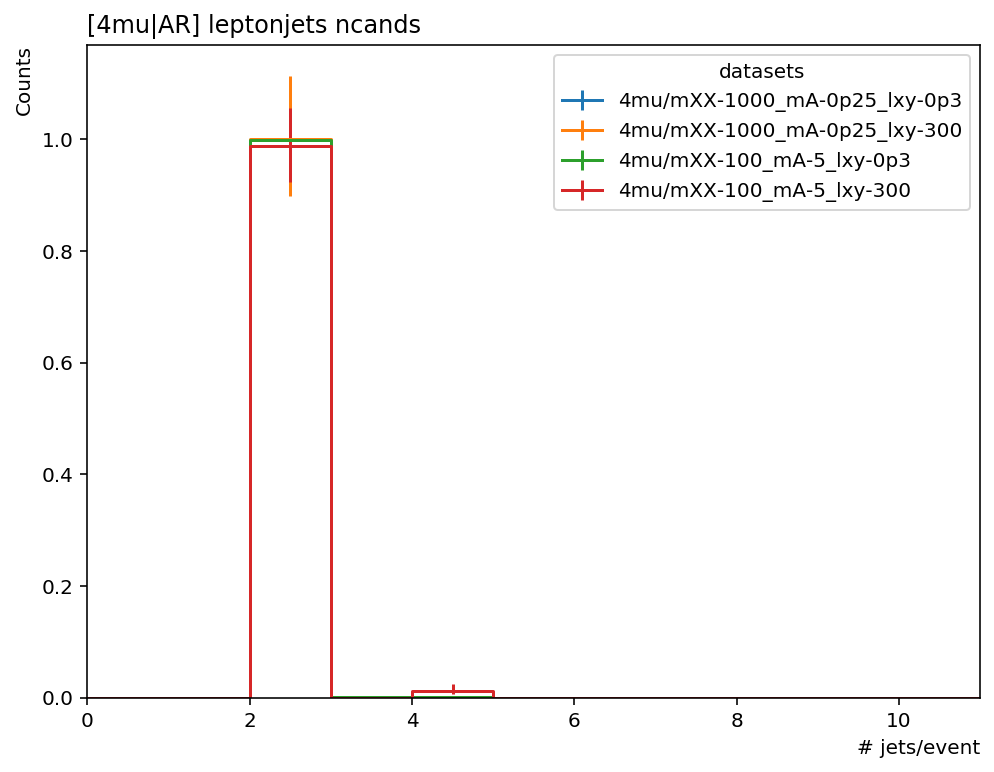

In [14]:
## This need to adjust the processor to select `ismutype` leptonjet
## otherwise the plot is not meaningful.

fig, ax=plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['ljcands']['4mu/*'].integrate('channel', slice(2,3)),
                   overlay='dataset',
                   ax=ax,
                   density=True,
                   overflow='over',)
# ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.vlines([-2.7, -2.6, 2.6, 2.7], 0, 1, transform=ax.get_xaxis_transform())
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[4mu|AR] leptonjets ncands', x=0.0, ha="left");